In [1]:
%matplotlib ipympl
# % matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
import netCDF4
import xarray as xr
import pandas as pd
import seaborn as sns
#plt.style.use('seaborn')
import os
from scipy import stats

#### Data Opening Functions

In [2]:
def data_opening_w_stripe(stripe, d):
    dsf_raw = xr.open_dataset(d,engine = 'netcdf4')  

    # FOR FUV A SWP
    if 'ICON_L1_FUVA_SWP_Center_Times' in dsf_raw.variables.keys():
        dsf = dsf_raw[['ICON_L1_FUVA_SWP_Center_Times','ICON_L1_FUVA_SWP_PROF_'+str(stripe)]]
        # Convert times to something Python and xarray can understand, and reindex the dataset by time 
        t = pd.to_datetime(dsf.ICON_L1_FUVA_SWP_Center_Times.values)
        dsf['time'] = (['Epoch'], t)
        dsf = dsf.swap_dims({'Epoch':'time'})
        dsf = dsf.rename({'Rows':'row'})
        # Rename and drop useless variables
        dsf['I_1356'] = dsf['ICON_L1_FUVA_SWP_PROF_'+str(stripe)]
        dsf = dsf.drop(['ICON_L1_FUVA_SWP_PROF_'+str(stripe),'ICON_L1_FUVA_SWP_Center_Times','Epoch'])
    
    # FOR FUV B LWP
    elif 'ICON_L1_FUVB_LWP_Center_Times' in dsf_raw.variables.keys():
        dsf = dsf_raw[['ICON_L1_FUVB_LWP_Center_Times','ICON_L1_FUVB_LWP_PROF_'+str(stripe)]]
        # Convert times to something Python and xarray can understand, and reindex the dataset by time 
        t = pd.to_datetime(dsf.ICON_L1_FUVB_LWP_Center_Times.values)
        dsf['time'] = (['Epoch'], t)
        dsf = dsf.swap_dims({'Epoch':'time'})
        dsf = dsf.rename({'Rows':'row'})
        #  Rename and drop useless variables
        dsf['N2'] = dsf['ICON_L1_FUVB_LWP_PROF_'+str(stripe)]
        dsf = dsf.drop(['ICON_L1_FUVB_LWP_PROF_'+str(stripe),'ICON_L1_FUVB_LWP_Center_Times','Epoch'])    
      
    return dsf

#### Orbit Separation Functions

In [3]:
def orbits_finder(df):
    from scipy.signal import find_peaks
    data = df.I_1356.mean(dim = 'row')
    data_np = data.to_numpy()
    np.shape(data)

    max_data = max(data_np)
    time_diff = pd.to_timedelta('75 m')
    half_time_diff = pd.to_timedelta('50 m')

    indices = find_peaks(data, height = max_data * (4/6)) 

    indexes = indices[0]
    indexes 

    final_indexes = []

    for i in range(0,len(indexes)-1):
        if len(indexes) > 15:
            if indexes[i+1] - indexes[i] < 200:
                pass
            else:
                final_indexes.append(indexes[i])
        else:
            final_indexes.append(indexes[i])
    final_indexes.append(indexes[-1])
    
    times_np = df.time.to_numpy()
    times_dt = pd.to_datetime(times_np)
    
    all_orbits = []
    for i in final_indexes:
        start_time = times_dt[i] - half_time_diff
        end_time = start_time + time_diff
        df_orbit = df.sel(time=slice(start_time, end_time))
        all_orbits.append(df_orbit)
        
    return all_orbits

In [155]:
def single_orb(orbit_arr,n):   
    orb = orbit_arr[n].mean(dim = 'row')
    t = orb.time

    
    if 'I_1356' in orb.variables.keys():
        val = orb.I_1356
    elif 'N2' in orb.variables.keys():
        val = orb.N2
        
    return(t, val)

#### Raw Counts Plot

In [5]:
def stripes_lineplot(n,day):
    plt.figure(figsize = (9,10))
    plt.title("Comparing Stripes of FUV Data for Orbit "+str(n)+ " on " + day +" 2020")

    plt.plot(single_orb(swp_p0_all,n)[0],single_orb(swp_p0_all,n)[1],marker = '.', label = 'PO SWP')
    plt.plot(single_orb(swp_p3_all,n)[0],single_orb(swp_p3_all,n)[1],marker = '.', label = 'P3 SWP')
    plt.plot(single_orb(swp_p6_all,n)[0],single_orb(swp_p6_all,n)[1],marker = '.', label = 'P6 SWP')
    plt.plot(single_orb(swp_m3_all,n)[0],single_orb(swp_m3_all,n)[1],marker = '.', label = 'M3 SWP')
    plt.plot(single_orb(swp_m6_all,n)[0],single_orb(swp_m6_all,n)[1],marker = '.', label = 'M6 SWP')
    plt.plot(single_orb(swp_m9_all,n)[0],single_orb(swp_m9_all,n)[1],marker = '.', label = 'M9 SWP')
    plt.legend()
    plt.show()


In [6]:
L1f_swp_01 = 'ICON_L1_FUV_SWP_2020-01-01_v05r000.NC'

In [7]:
# ALL STRIPES FOR SWP
swp_m9 = data_opening_w_stripe('M9',L1f_swp_01)
swp_m6 = data_opening_w_stripe('M6',L1f_swp_01)
swp_m3 = data_opening_w_stripe('M3',L1f_swp_01)
swp_p0 = data_opening_w_stripe('P0',L1f_swp_01)
swp_p3 = data_opening_w_stripe('P3',L1f_swp_01)
swp_p6 = data_opening_w_stripe('P6',L1f_swp_01)

# ALL 
swp_p0_all = orbits_finder(swp_p0)
swp_p3_all = orbits_finder(swp_p3)
swp_p6_all = orbits_finder(swp_p6)
swp_m3_all = orbits_finder(swp_m3)
swp_m6_all = orbits_finder(swp_m6)
swp_m9_all = orbits_finder(swp_m9)

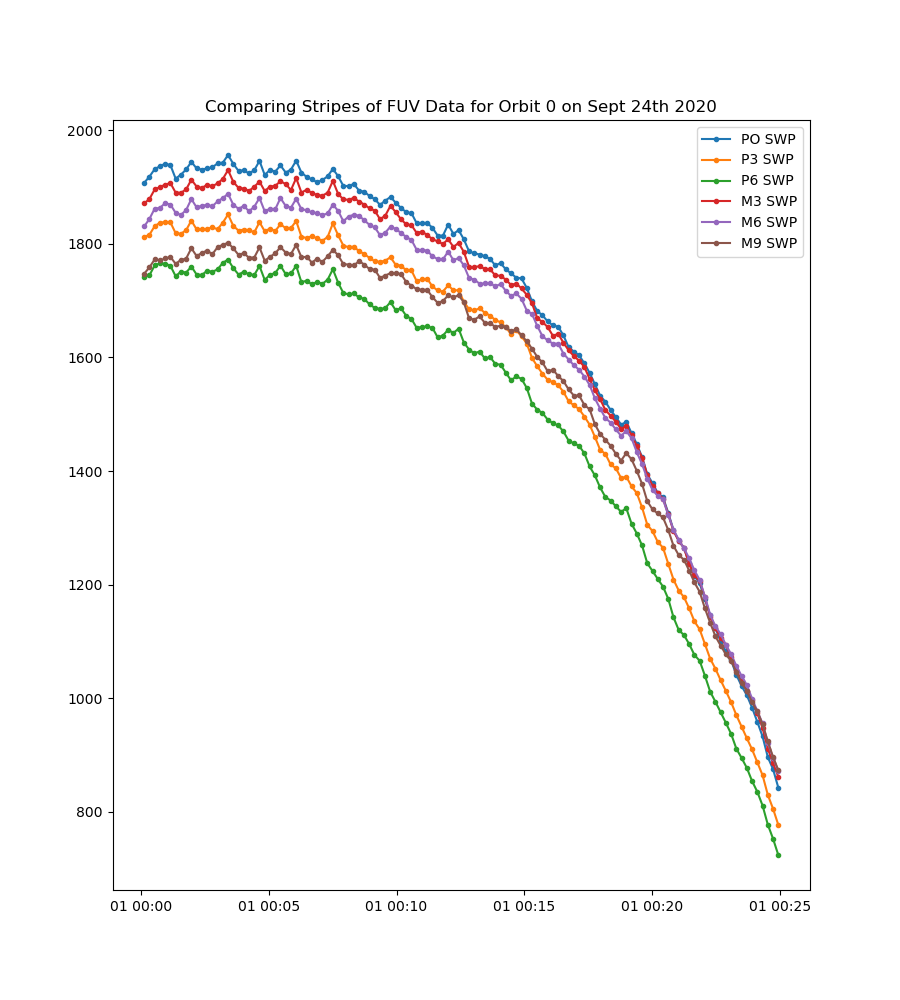

In [8]:
stripes_lineplot(0,'Sept 24th')

#### IDEA: PCA

In [10]:
# First must figure out how to get entirely uniform orbits (with same x axis scaling)
# Also must remove bad orbits agh

In [141]:
def orbits_finder_filt(df):
    from scipy.signal import find_peaks
    
    data = df.I_1356.mean(dim = 'row')
    
    time_diff = pd.to_timedelta('75 m')
    half_time_diff = pd.to_timedelta('50 m')
    # Instead of time_diff for slices, use a specific number of points on both sides of the peak (180)
    
    # Rolling Mean average over data 
    data_smoothed = data.rolling(time = 100, center = False).mean()

    indices = find_peaks(data_smoothed) 

    indexes = indices[0]
    indexes 

    final_indexes = []

    times_np = df.time.to_numpy()
    times_dt = pd.to_datetime(times_np)
    
    all_orbits = []
    for i in indexes:
        start_time = times_dt[i] - half_time_diff
        end_time = start_time + time_diff
        df_orbit = df.sel(time=slice(start_time, end_time))


        # ORBIT FILTERING

        arr = df_orbit.I_1356.mean(dim = 'row')
        
        zero_counter = 0

        # Y_val < 100
        for val in arr:
            if val <= 50:
                zero_counter += 1


        if zero_counter/len(arr) < 0.35 and len(arr) > 300: # check this lim         
            all_orbits.append(df_orbit)


    return all_orbits

In [142]:
L1f_swp_01 = 'ICON_L1_FUV_SWP_2020-11-04_v05r000.NC'
swp_p0 = data_opening_w_stripe('P0',L1f_swp_01)
swp_p0_all = orbits_finder_filt(swp_p0)

In [143]:
len(swp_p0_all) # ONLY 9 orbits vs 15!

9

In [148]:
swp_p0_all[0]

<xarray.Dataset>
Dimensions:  (row: 256, time: 365)
Coordinates:
  * row      (row) float32 0.0 1.0 2.0 3.0 4.0 ... 251.0 252.0 253.0 254.0 255.0
  * time     (time) datetime64[ns] 2020-11-04T00:30:31.917000 ... 2020-11-04T...
Data variables:
    I_1356   (time, row) float32 -3.531 -3.387 -3.231 ... -0.4659 -1.928 -0.9389
Attributes: (12/51)
    Acknowledgement:             This is a data product from the NASA Ionosph...
    ADID_Ref:                    NASA Contract > NNG12F45C
    Calibration_File:            See calibration files in general attribute f...
    Conventions:                 SPDF ISTP/IACF Modified for NetCDF (v0.8)
    Data_Level:                  L1
    Data_Type:                   APIDxE3 > ICON Application ID 0xE3: FUV Scie...
    ...                          ...
    FLATFIELD_CORRECTION:        [1.159 1.057 1.011 0.952 0.919 0.91 ]
    BACKGROUND_CORRECTION:       sw_bkg_2020-309.txt
    RAYLEIGH_CONVERSION:         [0.04407962 0.04407962 0.04407962 ... 0.0440...
    File_Date:                   Wed, 27 Apr 2022, 2022-04-27T00:11:45.043 UTC
    Generation_Date:             20220427
    Software_Version:            ICON SDC > ICON FUV L1 Processor version 202...

In [157]:
sel_orb = single_orb(swp_p0_all,0)
sel_orb[1]

<xarray.DataArray 'I_1356' (time: 365)>
array([ 6.19241095e+00,  5.67040825e+00,  6.19148493e+00,  6.13643932e+00,
        5.83898354e+00,  6.04419374e+00,  5.86352730e+00,  5.94340134e+00,
        6.14229774e+00,  4.63353443e+00,  4.40466118e+00,  4.00747490e+00,
        4.88266659e+00,  4.68462181e+00,  4.16177177e+00,  3.76242232e+00,
        4.38745499e+00,  4.36850929e+00,  3.75180817e+00,  3.78246808e+00,
        3.51611710e+00,  3.55526280e+00,  2.96059227e+00,  3.61088991e+00,
        3.60716176e+00,  3.52271605e+00,  3.98733783e+00,  3.53540993e+00,
        3.97166252e+00,  4.26574850e+00,  4.37013960e+00,  4.06691599e+00,
        4.35774279e+00,  3.89636660e+00,  4.10156536e+00,  3.56905055e+00,
        3.50311637e+00,  3.13029337e+00,  3.34975648e+00,  2.07684493e+00,
        2.29925084e+00,  2.05495310e+00,  1.44584763e+00,  1.56602395e+00,
        1.28637683e+00,  5.28055191e-01, -5.40721416e-02,  4.95087743e-01,
        3.52353096e-01,  6.00939274e-01,  1.91624045e-01, -1.99631429e+00,
       -2.01984787e+00, -3.56041312e-01, -2.21099257e-01, -3.94896507e-01,
       -9.45723891e-01, -4.61268425e-01, -7.86433816e-01, -1.04978430e+00,
       -9.57944393e-02, -6.52718544e-02, -6.49974048e-01,  7.87207484e-01,
        1.10451221e+00,  1.62213778e+00,  2.17102695e+00,  4.74356699e+00,
        6.16248703e+00,  1.00022621e+01,  1.40440063e+01,  1.90182991e+01,
        2.68987694e+01,  3.65627823e+01,  4.79016762e+01,  6.30111847e+01,
        7.95117874e+01,  9.95960770e+01,  1.21725647e+02,  1.49350967e+02,
...
        9.72023804e+02,  9.36704224e+02,  8.95938904e+02,  8.54220276e+02,
        8.12010132e+02,  7.68546509e+02,  7.33420593e+02,  6.96551147e+02,
        6.58496704e+02,  6.09691345e+02,  5.71833252e+02,  5.34349487e+02,
        4.92041138e+02,  4.50916077e+02,  4.18566101e+02,  3.76592529e+02,
        3.36831604e+02,  2.99030579e+02,  2.64756348e+02,  2.31134613e+02,
        2.00722351e+02,  1.75713135e+02,  1.50959610e+02,  1.27443779e+02,
        1.07027222e+02,  9.19975586e+01,  7.73500519e+01,  6.34361877e+01,
        5.42524796e+01,  4.65840263e+01,  3.91914139e+01,  3.46540756e+01,
        3.14337006e+01,  2.76263084e+01,  2.64467449e+01,  2.46778946e+01,
        2.20741692e+01,  2.22348061e+01,  2.06313248e+01,  1.95400677e+01,
        1.97042255e+01,  1.79118156e+01,  1.77262764e+01,  1.78749561e+01,
        1.80719395e+01,  1.62490673e+01,  1.69683113e+01,  1.72447605e+01,
        1.71947193e+01,  1.68414154e+01,  1.66965599e+01,  1.51124821e+01,
        1.58438082e+01,  1.55029068e+01,  1.47920713e+01,  1.41355791e+01,
        1.43527451e+01,  1.31377478e+01,  1.28640366e+01,  1.89140358e+01,
        2.38387642e+01,  2.35593166e+01,  2.17513657e+01,  2.20712090e+01,
        2.13994675e+01,  1.97621117e+01,  2.00453033e+01,  1.87909050e+01,
        1.79440956e+01,  1.76159744e+01,  1.57609310e+01,  1.39414730e+01,
        1.28946228e+01,  1.04728775e+01,  8.57737732e+00,  6.57148647e+00,
        4.42660904e+00], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-11-04T00:30:31.917000 ... 2020-11-04T...

364
365
365
365
365
365
365
365
365
365
303


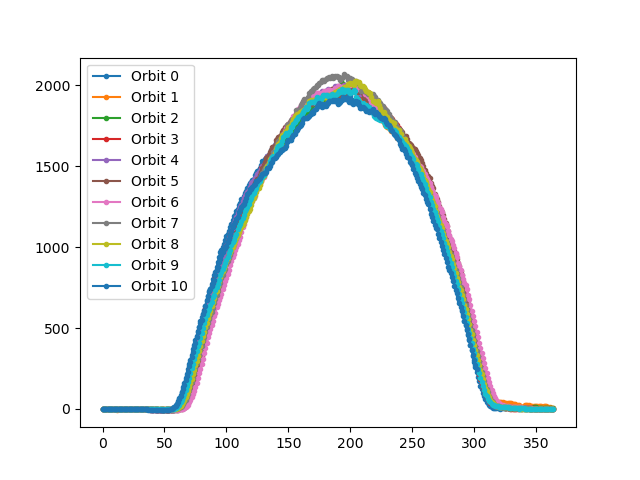

In [116]:
L1f_swp_01 = 'ICON_L1_FUV_SWP_2020-05-10_v05r000.NC'
swp_p0 = data_opening_w_stripe('P0',L1f_swp_01)
swp_p0_all = orbits_finder_filt(swp_p0)

plt.figure()
for i in range(0,len(swp_p0_all)):
    sel_orb = single_orb(swp_p0_all,i)
    plt.plot(sel_orb[1],marker = '.',label = "Orbit " + str(i))
    print(len(sel_orb[1]))
plt.legend()
plt.show()


325
365
365
365
365
335


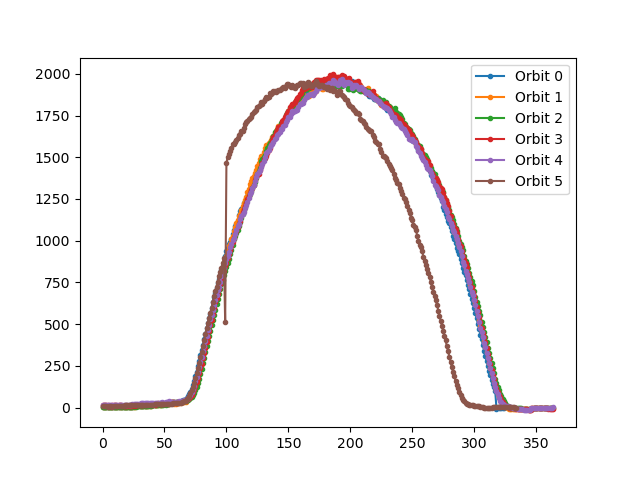

In [158]:
L1f_swp_01 = 'ICON_L1_FUV_SWP_2020-01-01_v05r000.NC'
swp_p0 = data_opening_w_stripe('P0',L1f_swp_01)
swp_p0_all = orbits_finder_filt(swp_p0)

plt.figure()
for i in range(0,len(swp_p0_all)):
    sel_orb = single_orb(swp_p0_all,i)
    plt.plot(sel_orb[1],marker = '.',label = "Orbit " + str(i))
    print(len(sel_orb[1]))
plt.legend()
plt.show()


364
365
365
365
365
365
365
312


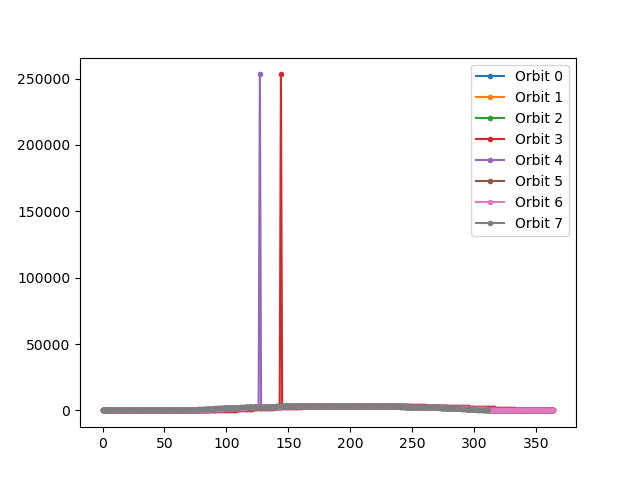

In [118]:
# WEIRD FUNKY DAY
L1f_swp_01 = 'ICON_L1_FUV_SWP_2020-11-30_v05r000.NC'
swp_p0 = data_opening_w_stripe('P0',L1f_swp_01)
swp_p0_all = orbits_finder_filt(swp_p0)

swp_norm = orbits_finder(swp_p0)
plt.figure()
for i in range(0,len(swp_p0_all)):
    sel_orb = single_orb(swp_p0_all,i)
    plt.plot(sel_orb[1],marker = '.',label = "Orbit " + str(i))
    print(len(sel_orb[1]))
plt.legend()
plt.show()


In [33]:
from IPython.display import display, clear_output

#### Everything!

In [121]:
# Define the directory path (change this to your directory)
directory_path = "/Users/pkoll/ICON_FUV"

# Use glob to find all files in the directory
file_pattern = os.path.join(directory_path, '*.nc')  
files = glob.glob(file_pattern)

orbits = []
counter = 0
counter2 = 0
counter3 = 0

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1) 

# Check if we found more than 1 file
if len(files) > 1:
    print(f"Found {len(files)} files. Processing...")

    # Iterate over the files and process each one
    for file_path in files:
        try:
           # print(file_path)
            file_name = os.path.basename(file_path)
           # print(file_name)
            
            swp_p0 = data_opening_w_stripe('P0',file_name)             
            
            # Day Name
            parts = file_name.split('_')
            day = parts[4]

            print("All Data Opened for", day)
            
            swp_p0_all = orbits_finder_filt(swp_p0)
            
            for i in range(0,len(swp_p0_all)):
                sel_orb = single_orb(swp_p0_all,i)

                if len(sel_orb[1]) == 365:
                    counter += 1
                    print(counter,len(sel_orb[1]))
                    
                    orbits.append(sel_orb[1])
                    
                    # for i in orbits:
                    #     ax.plot(i)
                    #     ax.cla()
                    #     display(fig)
                
                    #     clear_output(wait = True)
                    #     plt.pause(0.5)
                
                elif len(sel_orb[1]) == 364:
                    counter2 += 1
                   # print(type(sel_orb[1]))
                    print('364',counter2,len(sel_orb[1]))

                else:
                    counter3 += 1
                    print(len(sel_orb[1]))
                    print('OTHER',counter3,len(sel_orb[1]))
            
            # plt.figure(figsize = (10,15))
            
            # for i in orbits:
            #     plt.plot(i)
            # plt.show()

            print(f' DONE: Entirely Processed {day}')
        
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

else:
    print(f"Found only {len(files)} files. Not enough files to process.")

Found 131 files. Processing...
Error processing /Users/pkoll/ICON_FUV\ICON_L0P_FUV_Ancillary_2020-09-24_v03r002.NC: cannot access local variable 'dsf' where it is not associated with a value
All Data Opened for 2019-11-16
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2019-11-16_v05r001.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-01-01
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2020-01-01_v05r000.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-01-02
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2020-01-02_v05r001.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-03-22
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2020-03-22_v05r000.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-05-10
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2020-05-10_v05r000.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-01-01
325
OTHER 1 325
1 

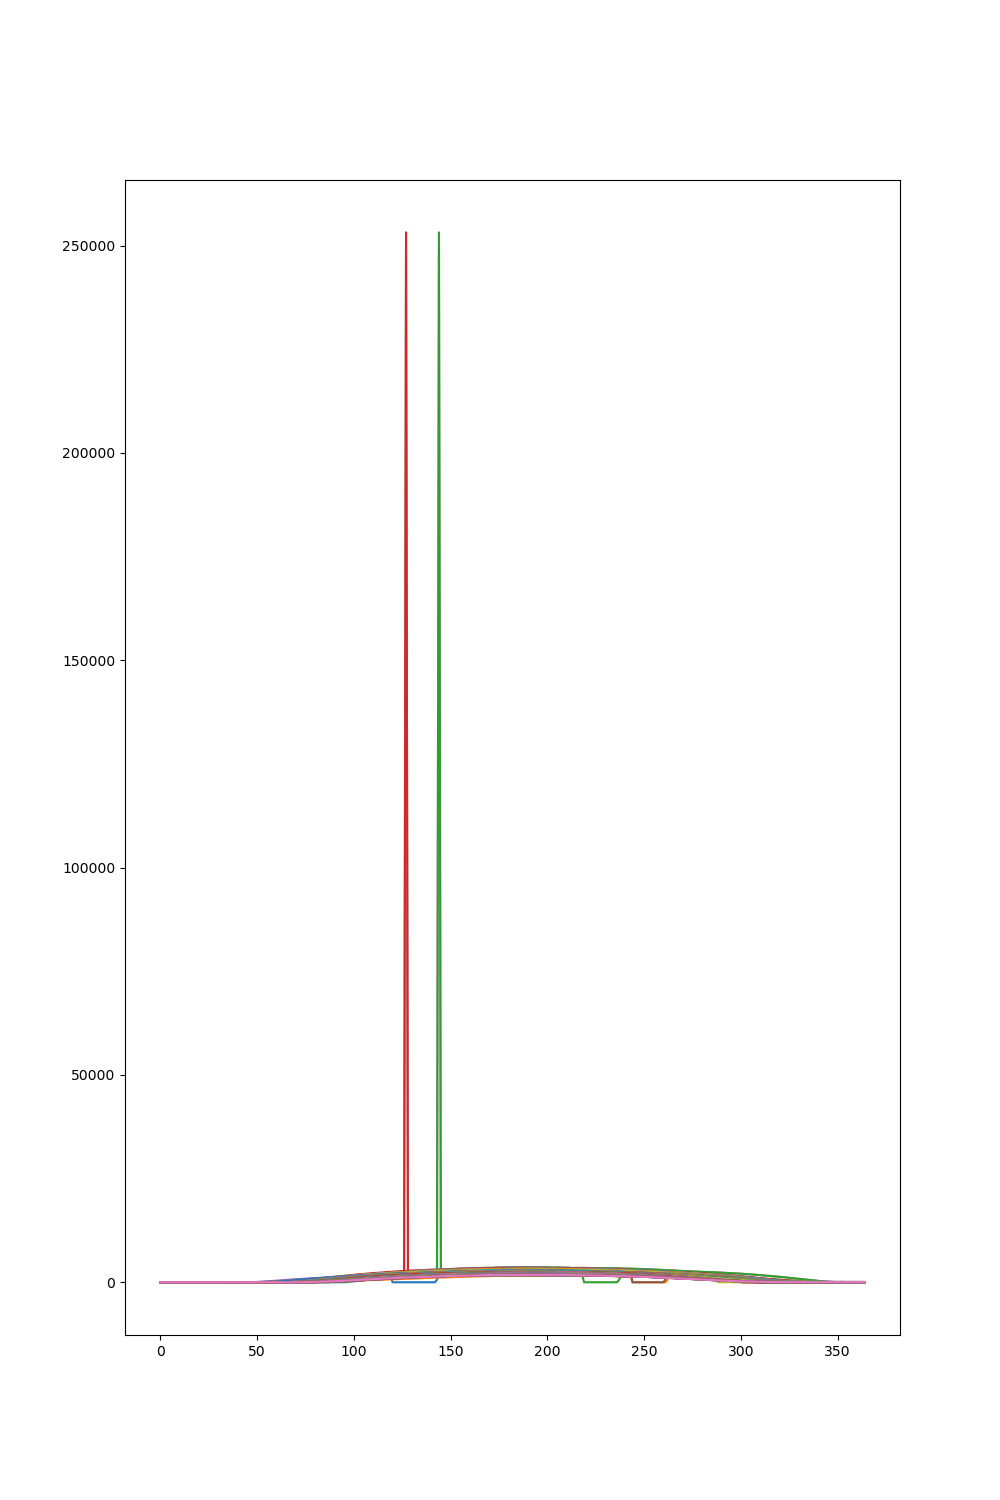

In [122]:
plt.figure(figsize = (10,15))
for i in orbits:
    plt.plot(i)
plt.show()


In [123]:
ds_list = []
orbit_num = 0

for da in orbits:

    
    ds = da.to_dataset()
    t = ds.time.copy()
    ds['time'] = np.arange(365)
    ds = ds.rename({'time':'index'})
    ds['time'] = (['index'], t.values)
    ds['orbit'] = orbit_num
    orbit_num += 1
    ds_list.append(ds)
ds = xr.concat(ds_list, dim='orbit')

In [124]:
ds

<xarray.Dataset>
Dimensions:  (index: 365, orbit: 737)
Coordinates:
  * index    (index) int32 0 1 2 3 4 5 6 7 8 ... 357 358 359 360 361 362 363 364
  * orbit    (orbit) int32 0 1 2 3 4 5 6 7 8 ... 729 730 731 732 733 734 735 736
Data variables:
    I_1356   (orbit, index) float32 2.942 2.943 2.728 ... 44.32 43.13 38.79
    time     (orbit, index) datetime64[ns] 2020-01-01T02:37:46.516000 ... 202...

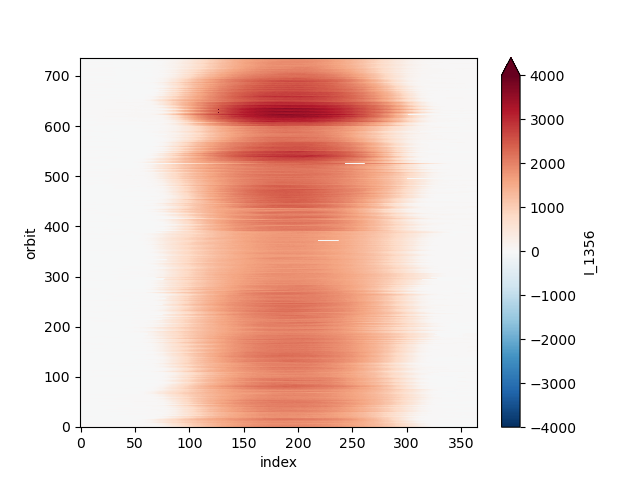

In [129]:
plt.figure()
ds.I_1356.plot(vmax=4000)

(-100.0, 4000.0)

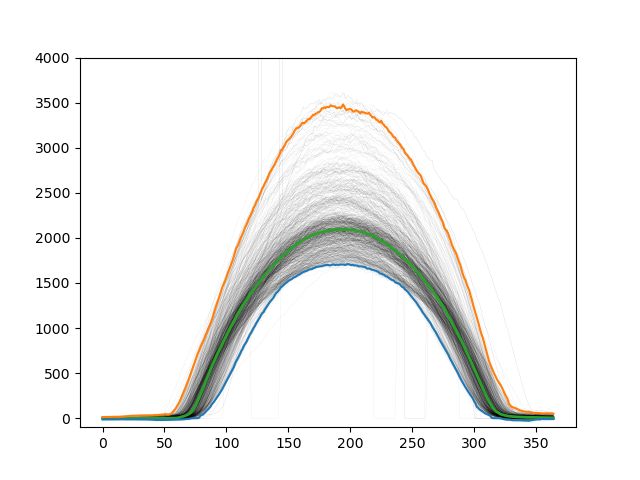

In [137]:
dsmedian = ds.median(dim='orbit')
ds05 = ds.quantile(0.01, dim='orbit')
ds95 = ds.quantile(0.99, dim='orbit')

plt.figure()
plt.plot(ds.index, ds.I_1356.T, 'k-', lw=0.1, alpha=0.2);

plt.plot(dsmedian.I_1356, 'C2-', lw=2)
plt.plot(ds05.I_1356, 'C0-')
plt.plot(ds95.I_1356, 'C1-')
plt.ylim((-100,4000))
# plt.plot(dsmedian.I_1356 + 3*dsstd.I_1356, 'k-')
# plt.plot(dsmedian.I_1356 - 3*dsstd.I_1356, 'k-')



C:\Users\pkoll\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

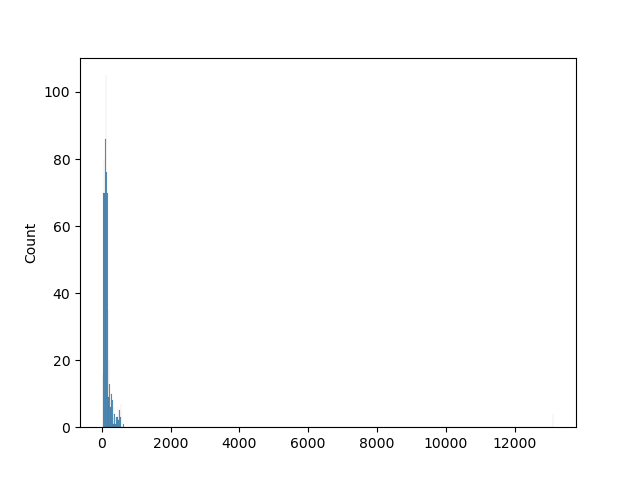

In [126]:
d = ds.I_1356 - dsmedian.I_1356
badness = d.std(dim='index')

plt.figure()
sns.histplot(badness)

(-100.0, 4000.0)

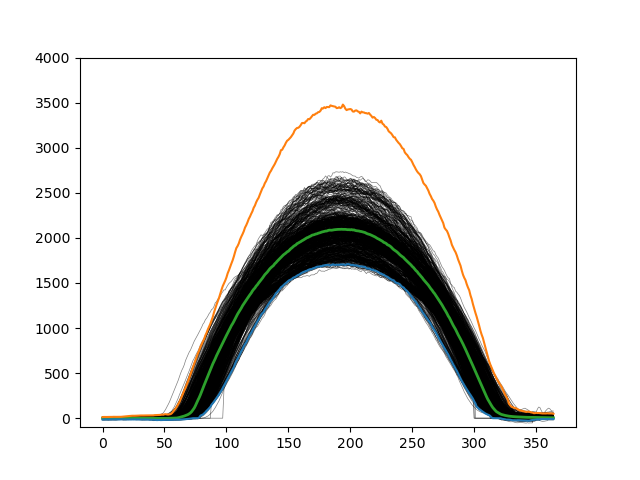

In [139]:
good = badness < 250

dsgood = ds.where(good, drop=True)

plt.figure()
plt.plot(dsgood.index, dsgood.I_1356.T, 'k-', lw=0.5, alpha=0.5);

plt.plot(dsmedian.I_1356, 'C2-', lw=2)
plt.plot(ds05.I_1356, 'C0-')
plt.plot(ds95.I_1356, 'C1-')
plt.ylim((-100,4000))

In [130]:
# WEIRD OUTLIER DAY
bad = ds.where(ds.I_1356 > 10000, drop=True)
bad.time

<xarray.DataArray 'time' (orbit: 4, index: 2)>
array([[                          'NaT', '2020-11-30T07:14:22.921000000'],
       ['2020-11-30T07:14:22.921000000',                           'NaT'],
       [                          'NaT', '2020-11-30T07:14:22.921000000'],
       ['2020-11-30T07:14:22.921000000',                           'NaT']],
      dtype='datetime64[ns]')
Coordinates:
  * index    (index) int32 127 144
  * orbit    (orbit) int32 626 627 632 633

In [131]:
dsday = ds.where(ds.time.dt.date == datetime.date(2020,11,30), drop=True)

In [132]:
dsday

<xarray.Dataset>
Dimensions:  (orbit: 12, index: 365)
Coordinates:
  * index    (index) int32 0 1 2 3 4 5 6 7 8 ... 357 358 359 360 361 362 363 364
  * orbit    (orbit) int32 624 625 626 627 628 629 630 631 632 633 634 635
Data variables:
    I_1356   (orbit, index) float32 0.6196 -0.6374 -0.4616 ... 23.7 24.4 23.69
    time     (orbit, index) datetime64[ns] 2020-11-30T02:00:22.576000 ... 202...

In [ ]:
### PCA CODE

from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import model_selection
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df_u
y = df_drift_mer


#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#sc = StandardScaler()
#sc.fit(X_train)
#sc.fit(X_test)

#X_reduced_train = sc.transform(X_train)
#X_reduced_test = sc.transform(X_test)


pca = PCA()
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

model = LinearRegression(fit_intercept=True)
model.fit(X_train_pca, y_train)

y_pred_test_pca = model.predict(X_test_pca)
y_pred_train_pca = model.predict(X_train_pca)

from sklearn.metrics import r2_score
r2_train = r2_score(y_train, y_pred_train_pca)
r2_test = r2_score(y_test, y_pred_test_pca)
print(r2_train,r2_test)

In [ ]:
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)

plt.figure()
plt.plot(var, '-o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance')
plt.title('Variance vs Number of Principal Components') 
plt.axvline(8)
plt.show()